In [1]:
import IPython.display as disp
%matplotlib inline
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


In [2]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=CkfUbiJFIesAHcM_P-TWHMtMg98Z56TjmlL4cBCJa6Y&tc=W2oQVlc-6YYU7H8_CTcvsXQa3UmPbf8NCySuefqRIc8&cc=-ieVMwRrHQmzVUXCh5s6Akso-ehwaccwkvX_RGR7wWE

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjt0rYO2EZ3dkKnbG6eHbPBtVraplcilt-ZxTPhfnEYvhS4iJ2zJdI

Successfully saved authorization token.


In [3]:
import numpy as np
import time

def make_aoi(bounds, crs='epsg:4326'):
  
  return ee.Geometry.Rectangle(list(bounds), proj=crs, evenOdd=False)

In [4]:
# Indus Valley
aoi = make_aoi([71.591810, 33.787081, 71.861319, 34.049260])
crs = 'EPSG:4326'

# IV Agricultural Zones
aoi = make_aoi([69.408526, 28.004267, 69.930628, 28.532871])
crs = 'EPSG:4326'

In [5]:
def get_LSAT5_dataset(aoi, date_start, date_end):
  dataset = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                .filterBounds(aoi)\
                .filterDate(date_start, date_end)\
                .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))

  return dataset

def get_LSAT5_dataset(aoi, date_start, date_end):
  dataset = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")\
                .filterBounds(aoi)\
                .filterDate(date_start, date_end)
  return dataset

In [6]:
ds = get_LSAT5_dataset(aoi, '2000-11-18', '2001-11-19')

In [7]:
nn = ds.size().getInfo()
lst = ds.toList(nn)
print(nn,'images retrieved')

62 images retrieved


In [8]:
from collections import defaultdict
img_dict = defaultdict(list)
for ii in range(nn):
  img = lst.get(ii)
  inf = img.getInfo()['properties']
  key = int(inf['system:time_start']/1000000.)
  img_dict[key].append((inf['system:index'].split('_')[-1], img))

In [9]:
print(key)

987744


In [9]:
for key in sorted(img_dict.keys()):
  imgcoll = ee.ImageCollection.fromImages([x[1] for x in img_dict[key]])
  img = imgcoll.mosaic().clip(aoi)
  fname = 'IndusValleyAg_%s' % img_dict[key][0][0]
  print(fname)
  ee.batch.Export.image.toDrive(image = img.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'QA_PIXEL']).toUint16(),folder='IndusValleyAgLD2000-2001v2',fileNamePrefix = fname,crs=crs,scale=10).start()

IndusValleyAg_20001120
IndusValleyAg_20001127
IndusValleyAg_20001206
IndusValleyAg_20001213
IndusValleyAg_20001222
IndusValleyAg_20001229
IndusValleyAg_20010107
IndusValleyAg_20010123
IndusValleyAg_20010130
IndusValleyAg_20010208
IndusValleyAg_20010215
IndusValleyAg_20010224
IndusValleyAg_20010303
IndusValleyAg_20010312
IndusValleyAg_20010312
IndusValleyAg_20010319
IndusValleyAg_20010328
IndusValleyAg_20010404
IndusValleyAg_20010420
IndusValleyAg_20010429
IndusValleyAg_20010506
IndusValleyAg_20010515
IndusValleyAg_20010522
IndusValleyAg_20010531
IndusValleyAg_20010616
IndusValleyAg_20010702
IndusValleyAg_20010709
IndusValleyAg_20010718
IndusValleyAg_20010803
IndusValleyAg_20010810
IndusValleyAg_20010826
IndusValleyAg_20010904
IndusValleyAg_20010911
IndusValleyAg_20010920
IndusValleyAg_20010927
IndusValleyAg_20011006
IndusValleyAg_20011013
IndusValleyAg_20011022
IndusValleyAg_20011029
IndusValleyAg_20011107
IndusValleyAg_20011114


In [10]:
imgcoll = ee.ImageCollection.fromImages([x[1] for x in img_dict[1632118]])

In [11]:
img = imgcoll.mosaic().clip(aoi)

In [12]:
img = ee.Image(lst.get(2))

In [13]:
img

Check https://code.earthengine.google.com/ to see the progress.

In [14]:
maxvalue = 65536.

In [15]:
rgb = ee.Image.rgb(img.select('SR_B3').toFloat().divide(maxvalue),
                   img.select('SR_B2').toFloat().divide(maxvalue),
                   img.select('SR_B1').toFloat().divide(maxvalue))

In [18]:
location = aoi.centroid(maxError=20).coordinates().getInfo()[::-1]

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S2 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [0, 0, 0], 'max': [0.25, 0.25, 0.25]}, 'rgb')


# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [17]:
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Rectangle",
    "arguments": {
      "coordinates": {
        "constantValue": [
          69.408526,
          28.004267,
          69.930628,
          28.532871
        ]
      },
      "crs": {
        "functionInvocationValue": {
          "functionName": "Projection",
          "arguments": {
            "crs": {
              "constantValue": "epsg:4326"
            }
          }
        }
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

In [18]:
%%capture

!pip install rioxarray

In [19]:
import numpy as np
import xarray as xa
import rioxarray as riox

import folium
from folium import plugins
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from glob import glob

In [20]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_rgb_composite(raster):
    """Creates an RGB composite image using the input raster."""
    r = raster[2]
    g = raster[1]
    b = raster[0]

    return make_composite(r, g, b)

def calculate_ndvi(raster):
    """Calculates the normalised difference vegetation index using the input raster."""
    r = raster[2]
    nir = raster[3]

    return (nir - r) / (nir + r)

def calculate_ndwi(raster):
    """Calculates the normalised difference water index using the input raster."""
    g = raster[1]
    nir = raster[3]

    return (g - nir) / (g + nir)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
filepath = "/content/drive/My Drive/IndusValleyAgLD2000-2001"
os.chdir(filepath)

In [24]:
sorted(glob('*.tif'))

['IndusValleyAg_20001120.tif']

In [46]:
s2_filepath = sorted(glob('IndusValleyAg_20*.tif'))[2]

s2_raster = riox.open_rasterio(s2_filepath)[:-1]/10000 # Scaled R, G, B and NIR bands.
cloud_prob_map = riox.open_rasterio(s2_filepath)[-1] # Unscaled cloud probability map.

display(s2_raster, cloud_prob_map)

<xarray.DataArray (band: 4, y: 5885, x: 5813)>
array([[[1.422 , 1.422 , 1.4122, ..., 1.0852, 1.0852, 1.1914],
        [1.422 , 1.422 , 1.4122, ..., 1.1808, 1.1808, 1.2546],
        [1.4514, 1.4514, 1.4709, ..., 1.1808, 1.1808, 1.2546],
        ...,
        [1.0522, 1.0522, 1.0522, ..., 1.1306, 1.1306, 1.1515],
        [1.0522, 1.0522, 1.0522, ..., 1.1306, 1.1306, 1.1515],
        [1.0304, 1.0304, 1.0304, ..., 1.1306, 1.1306, 1.1515]],

       [[1.746 , 1.746 , 1.726 , ..., 1.2377, 1.2377, 1.323 ],
        [1.746 , 1.746 , 1.726 , ..., 1.323 , 1.323 , 1.4291],
        [1.7857, 1.7857, 1.7857, ..., 1.323 , 1.323 , 1.4291],
        ...,
        [1.1874, 1.1874, 1.1874, ..., 1.3336, 1.3336, 1.3336],
        [1.1874, 1.1874, 1.1874, ..., 1.3336, 1.3336, 1.3336],
        [1.1656, 1.1656, 1.1656, ..., 1.3336, 1.3336, 1.3336]],

       [[1.9858, 1.9858, 1.9379, ..., 1.2593, 1.2593, 1.3947],
        [1.9858, 1.9858, 1.9379, ..., 1.3947, 1.3947, 1.5295],
        [1.9858, 1.9858, 1.9858, ..., 1.3947, 1.3947, 1.5295],
        ...,
        [1.2211, 1.2211, 1.2211, ..., 1.4355, 1.4355, 1.4188],
        [1.2211, 1.2211, 1.2211, ..., 1.4355, 1.4355, 1.4188],
        [1.1866, 1.1866, 1.1866, ..., 1.4355, 1.4355, 1.4188]],

       [[2.112 , 2.112 , 2.0746, ..., 1.4421, 1.4421, 1.5589],
        [2.112 , 2.112 , 2.0746, ..., 1.5395, 1.5395, 1.6753],
        [2.1308, 2.1308, 2.1308, ..., 1.5395, 1.5395, 1.6753],
        ...,
        [1.6098, 1.6098, 1.6098, ..., 1.5583, 1.5583, 1.5583],
        [1.6098, 1.6098, 1.6098, ..., 1.5583, 1.5583, 1.5583],
        [1.6693, 1.6693, 1.6693, ..., 1.5583, 1.5583, 1.5583]]])
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 69.41 69.41 69.41 69.41 ... 69.93 69.93 69.93 69.93
  * y            (y) float64 28.53 28.53 28.53 28.53 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0

<xarray.DataArray (y: 5885, x: 5813)>
[34209505 values with dtype=uint16]
Coordinates:
    band         int64 5
  * x            (x) float64 69.41 69.41 69.41 69.41 ... 69.93 69.93 69.93 69.93
  * y            (y) float64 28.53 28.53 28.53 28.53 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'QA_PIXEL')

In [47]:
rgb = make_rgb_composite(s2_raster)
ndvi = calculate_ndvi(s2_raster)
ndwi = calculate_ndwi(s2_raster)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


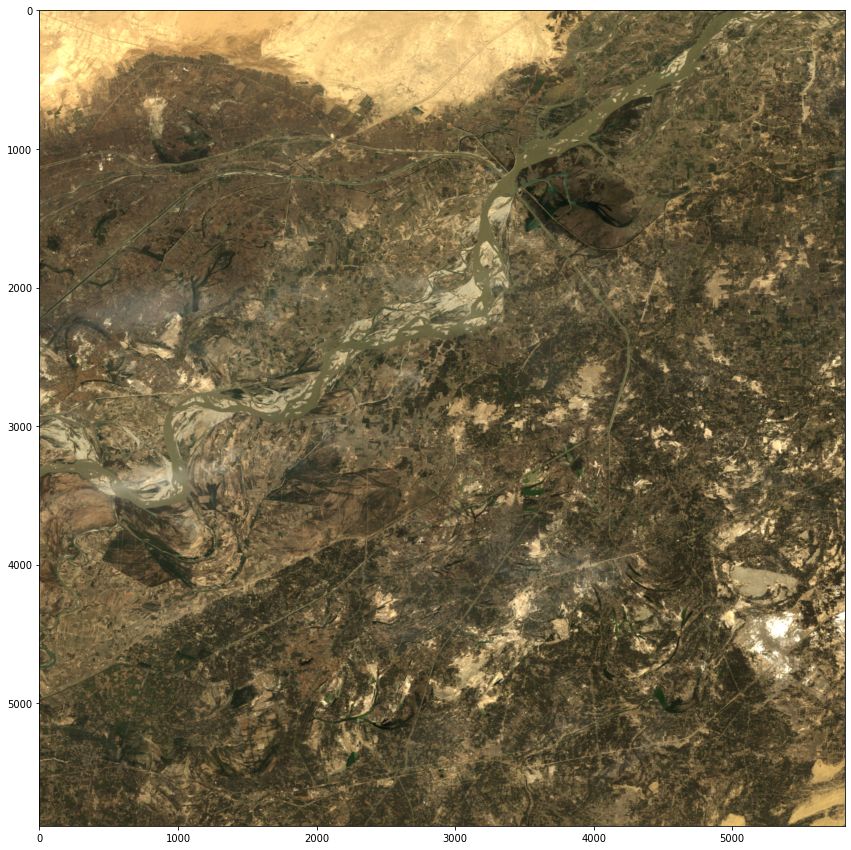

In [48]:
plt.subplots(figsize=(15,15))
plt.imshow(2*rgb)

In [49]:
obj = riox.open_rasterio(s2_filepath)

In [50]:
obj.coords

Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 69.41 69.41 69.41 69.41 ... 69.93 69.93 69.93 69.93
  * y            (y) float64 28.53 28.53 28.53 28.53 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0

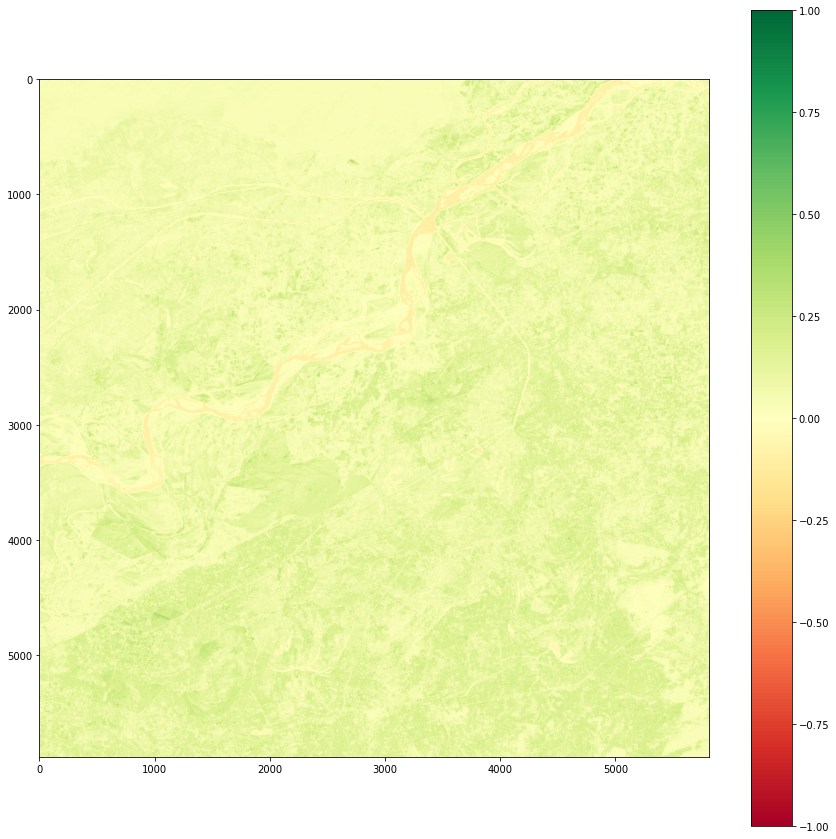

In [51]:
plt.subplots(figsize=(15,15))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax =1)
plt.colorbar();

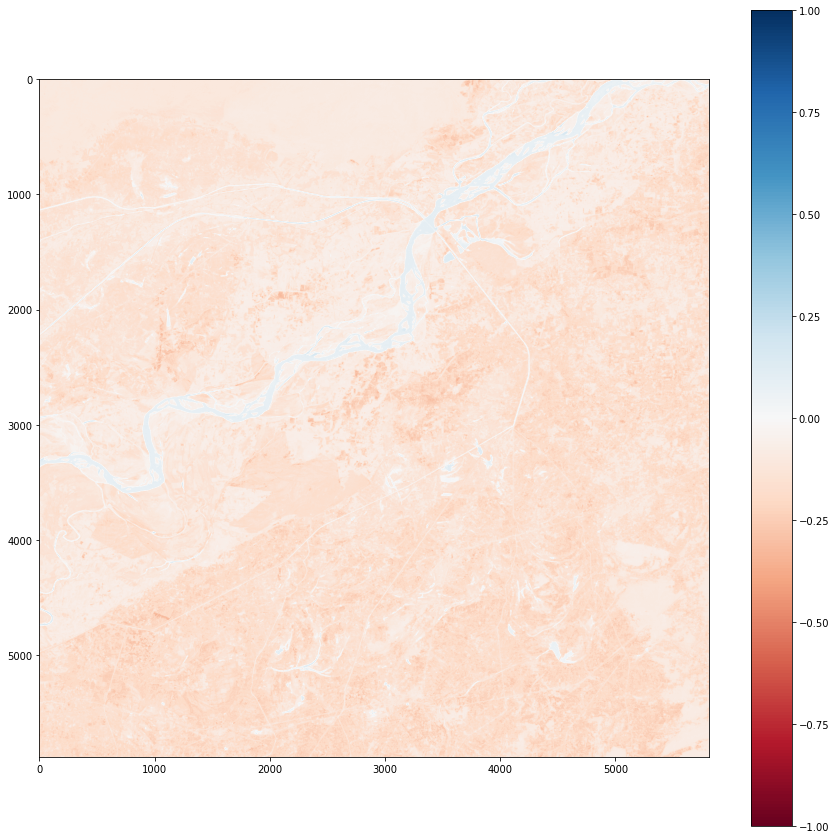

In [37]:
plt.subplots(figsize=(15,15))
plt.imshow(ndwi, cmap='RdBu', vmin=-1, vmax =1)
plt.colorbar();

In [ ]:
plt.hist(ndvi.data[::10,::10].ravel());

In [ ]:
s2_raster.dtype